<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="Rossum"></p>

<h1 style="text-align: center;">Deep Learning<br><br>Session - 8<br><br>Image Classification with CNN<br><br>Cat-Dog Classification Project Solution<br><h1>

# Dataset Info

The Dogs vs. Cats dataset is a common computer vision dataset in which pictures are classified as either including a dog or a cat.

After the dataset is well studied, it can be used to understand and practice how to design, evaluate, and apply convolutional neural networks for image classification.

You will build a classifier with images and try to detect dogs versus cats using CNN.

Train set includes 12500 cat-5026 dog images, validation set includes 1219 cat-1071 dog images and test set incgludes 6897 cat and dogs images together. 

# Import Libraries and Export Images from Zip_File

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

#import warnings
#warnings.filterwarnings("ignore")
#warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

In [2]:
import tensorflow as tf

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile

# Unzip the file
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/cat_dog_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

# Recognizing and Understanding Data

In [5]:
my_data_dir = 'data'

In [6]:
os.listdir(my_data_dir)

['validation', 'test', 'train']

In [7]:
val_path = my_data_dir+'/validation/'
train_path = my_data_dir+'/train/'
test_path = my_data_dir+'/test/'

In [8]:
os.listdir(train_path)

['cat', 'dog']

In [9]:
os.listdir(val_path)

['cat', 'dog']

In [10]:
os.listdir(test_path)[:5]

['3596.jpg', '4636.jpg', '11438.jpg', '2773.jpg', '3167.jpg']

In [11]:
# Alternative method
import pathlib

data_dir = pathlib.Path(train_path) # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['cat' 'dog']


**Let's check how many images there are.**

In [12]:
len(os.listdir(train_path+'cat')), len(os.listdir(train_path+'dog'))

(12500, 5026)

In [13]:
len(os.listdir(val_path+'cat')), len(os.listdir(val_path+'dog'))

(1219, 1071)

In [14]:
# Walk through cell_images directory and list number of files
for dirpath, dirnames, filenames in os.walk(my_data_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'data'.
There are 2 directories and 0 images in 'data/validation'.
There are 0 directories and 1219 images in 'data/validation/cat'.
There are 0 directories and 1071 images in 'data/validation/dog'.
There are 0 directories and 6897 images in 'data/test'.
There are 2 directories and 0 images in 'data/train'.
There are 0 directories and 12500 images in 'data/train/cat'.
There are 0 directories and 5026 images in 'data/train/dog'.


**Let's take an example images from both train-cat and train-dog folders to observe process** 

In [15]:
os.listdir(train_path+'cat')[0]


'cat.9973.jpg'

In [16]:
os.listdir(train_path+'dog')[0]


'dog.169.jpg'

In [17]:
path1=train_path+'cat'+'/cat.4593.jpg'
path2=train_path+'dog'+'/dog.10086.jpg'

In [18]:
cat_img=imread(path1)
dog_img=imread(path2)

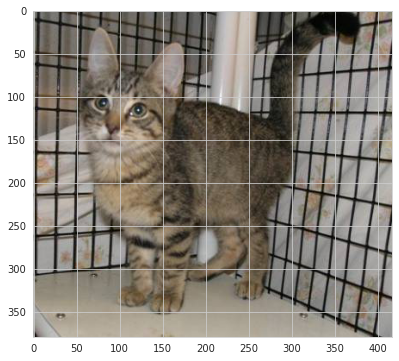

In [19]:
plt.imshow(cat_img)

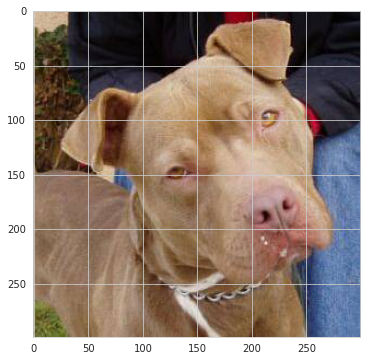

In [20]:
plt.imshow(dog_img)

In [21]:
# View an image
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (375, 499, 3)


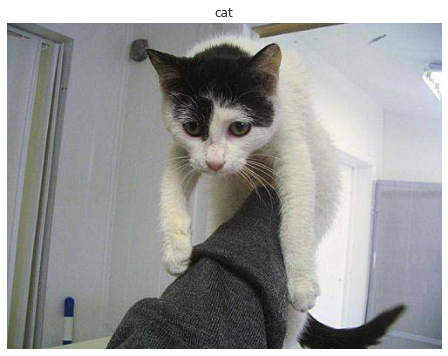

In [22]:
# View a random image from the training dataset
img = view_random_image(target_dir=train_path,
                        target_class="cat")

Image shape: (375, 499, 3)


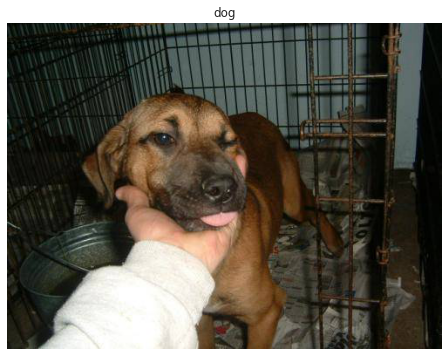

In [24]:
# View a random image from the training dataset
img = view_random_image(target_dir=train_path,
                        target_class="dog")

Image shape: (360, 255, 3)


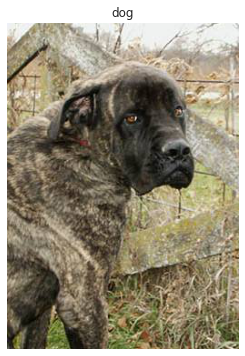

In [25]:
# View a random image from the training dataset
import random
img = view_random_image(target_dir=train_path,
                        target_class=random.choice(class_names)) # get a random class name

# Data Preprocessing

## Defining Input Shape

**Let's decide on the final dimension of these images.**

In [26]:
cat_img.shape

(379, 417, 3)

In [27]:
dog_img.shape

(299, 300, 3)

In [28]:
x = [imread(train_path+'cat/'+image).shape[0] for image in os.listdir(train_path+'cat')]
y = [imread(train_path+'cat/'+image).shape[1] for image in os.listdir(train_path+'cat')]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


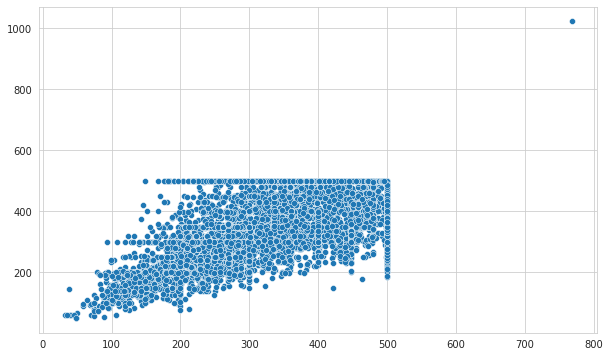

In [29]:
sns.scatterplot(x,y);

In [30]:
np.mean(x), np.median(x)

(356.46712, 374.0)

In [31]:
np.mean(y), np.median(y)

(410.52264, 470.0)

In [32]:
image_shape = (128,128,3)
# Channel sayısı zaten 3 idi o yüzden burada muhafaza ettik.
# Burada image_shape 128,128 aldık çünkü büyük resimleri küçültmek kolay ancak küçük resimleri büyülymek zor
# Ayrıca doğruluk ve hız için küçük aralık seçilebilir.
# Bu değerler ortalama ve median'a göre de seçilebilir. Burada bu değerler çok yüksek olduğu için 128*128 seçtik.
# 100*100 lük resmi 374*400'e getirirken çok fazla kayıp olabilir.

## Scalling

**Let's check the images if they are needed to be scaled or not**

In [33]:
cat_img.max()

255

In [34]:
cat_img.min()
# Datamız scale edilmemiş.
# Image Data Generator içinde scale edeceğiz.

0

As we see above, images need to be scaled

## Image Data Generator

**Image Manipulation**

We can use the ImageDataGenerator to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. ImageDataGenerator does the followings.

* Accepts a batch of images used for training.
* Applies a series of random transformations to each image in the batch.
* Replaces the original batch with randomly transformed batch.
* Training the CNN on this randomly transformed batch.

The goal of applying data augmentation is to have a more generalized model.

Data augmentation is a way to try and prevent a model overfitting. If your model is overfiting (e.g. the validation loss keeps increasing), you may want to try using data augmentation.

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [36]:
# help(ImageDataGenerator)

In [37]:
image_gen = ImageDataGenerator(rotation_range=15, # rotate the image 15 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 10%
                               height_shift_range=0.10, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allow horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )
# Burada rotation range projeye göre değişebilir. Eğer random bir şekilde tarayıcıya giriyorsa 180 bile seçilebilir.
# sağa ve sola shift direnci olarak %10 seçtik.
# shear budama demektir. Kenarlardan %10 budayabilir dedik.
# Resimde shidt olduysa bir miktar boşluk olacağı için fill_mode="nearest" ile en yakında bulunan değerle dolduracak.


In [38]:
image_gen2 = ImageDataGenerator(rescale=1/255) # Rescale the image by normalzing it.
                              
# Burada iki tane image_gen oluşturduk. Birini train için birini validation için kullanacağız.
# Validation datasının değişmesini istemediğimiz için image_gen2'yi orada kullanacağız.
# image_gen overfitting'i önler ve sample sayısını artırır böylece modelin daha iyi öğrenmesini sağlar.

                              

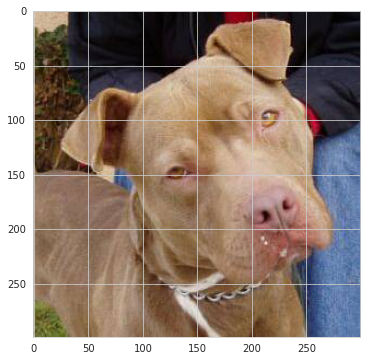

In [39]:
plt.imshow(dog_img);

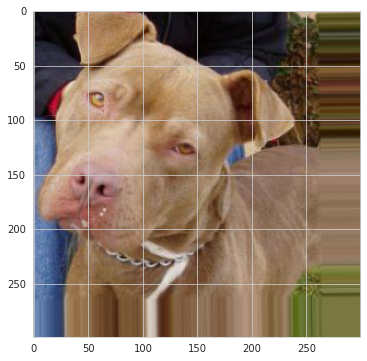

In [40]:
plt.imshow(image_gen.random_transform(dog_img));
# Yukarıdaki köpek resmini rasgele bir transform'a sokunca shift, fill ve flip yaptığını anlahyabiliyoruz.

### Taking the path to a directory & Generating batches of augmented data

flow_from_directory function works with images organized in sub-directories. Your directories should include only one class of images, so one folder per class of images.

In [41]:
#help(image_gen.flow_from_directory)
#Takes the path to a directory & generates batches of augmented data.
# Augmented data : arttırılmış data.

In [42]:
image_gen.flow_from_directory(train_path)

Found 17526 images belonging to 2 classes.


In [43]:
image_gen.flow_from_directory(val_path)

Found 2290 images belonging to 2 classes.


In [44]:
image_gen.flow_from_directory(test_path)

Found 0 images belonging to 0 classes.


In [45]:
batch_size = 32
# batch_size küçüldükçe hassasiyet artar ancak train süresi uzar.

In [46]:
train_image_gen = image_gen.flow_from_directory(directory=train_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',# channel 3 olduğu için rgb yazdık.
                                                batch_size=batch_size,
                                                class_mode='binary',
                                                shuffle=True)

Found 17526 images belonging to 2 classes.


In [47]:
val_image_gen = image_gen2.flow_from_directory(directory=val_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=False)
# validation datası için de sadece scaling(normalization) yaptık.
# Tercih meselesi,buraya da image_gen uygulanabilirdi.
# Shuffle=False yaptık çünkü evaluation yaparken sıralamada bozulma olmasını istemiyoruz.

Found 2290 images belonging to 2 classes.


In [48]:
train_image_gen.class_indices

{'cat': 0, 'dog': 1}

In [61]:
train_image_gen[0][0].shape

(32, 128, 128, 3)

In [62]:
len(train_image_gen), len(val_image_gen)
# Buradan train ve test için kaç tane batch'imiz olacağını görüyoruz.

(548, 72)

In [63]:
len(train_image_gen)*batch_size, len(val_image_gen)*batch_size 

(17536, 2304)

In [64]:
# Get a sample of the training data batch 
images, labels = train_image_gen.next() # get the 'next' batch of images/labels
len(images), len(labels)

(32, 32)

In [65]:
# Get a sample of the testing data batch 
images, labels = val_image_gen.next() # get the 'next' batch of images/labels
len(images), len(labels)

(32, 32)

# Modelling-1

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [67]:
model1 = Sequential()

model1.add(Conv2D(filters=16, kernel_size=(3,3),input_shape=image_shape, activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())

# Convolution  ve pooling işlemi sonrasi deep learing neural network'e geçiyoruz.

model1.add(Dense(128))
model1.add(Activation('relu'))

model1.add(Dense(64))
model1.add(Activation('relu'))

model1.add(Dense(1))
model1.add(Activation('sigmoid'))

model1.compile(loss='binary_crossentropy', #binary classification olduğu için "binary_crossentropy seçtik."
              optimizer='adam',
              metrics=['accuracy'])

In [68]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [69]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights = True)

In [70]:
model1.fit(train_image_gen,
          epochs=10,
          steps_per_epoch=len(train_image_gen), 
          validation_data=val_image_gen,       
          validation_steps=len(val_image_gen),
          callbacks=[early_stop])

# steps_per_epoch = len(train_image_gen):
    # image_gen ne kadar değişik resimler üretsin? - folder'daki sayı kadar dedik.
    # folder bitince olay bitiyor. *2, *3 yaparsak iterasyon sayımız artar. Datamızı 2ye 3e katlar.

Epoch 1/10
548/548 [==============================] - 113s 189ms/step - loss: 0.5828 - accuracy: 0.7157 - val_loss: 0.6394 - val_accuracy: 0.6297
Epoch 2/10
548/548 [==============================] - 106s 193ms/step - loss: 0.5187 - accuracy: 0.7531 - val_loss: 0.5822 - val_accuracy: 0.6987
Epoch 3/10
548/548 [==============================] - 107s 195ms/step - loss: 0.4574 - accuracy: 0.7904 - val_loss: 0.4822 - val_accuracy: 0.7747
Epoch 4/10
548/548 [==============================] - 107s 196ms/step - loss: 0.4135 - accuracy: 0.8160 - val_loss: 0.4162 - val_accuracy: 0.8122
Epoch 5/10
548/548 [==============================] - 103s 188ms/step - loss: 0.3732 - accuracy: 0.8322 - val_loss: 0.4269 - val_accuracy: 0.8214
Epoch 6/10
548/548 [==============================] - 104s 191ms/step - loss: 0.3488 - accuracy: 0.8494 - val_loss: 0.3779 - val_accuracy: 0.8402
Epoch 7/10
548/548 [==============================] - 106s 193ms/step - loss: 0.3192 - accuracy: 0.8619 - val_loss: 0.3499 -

In [71]:
summary = pd.DataFrame(model1.history.history)

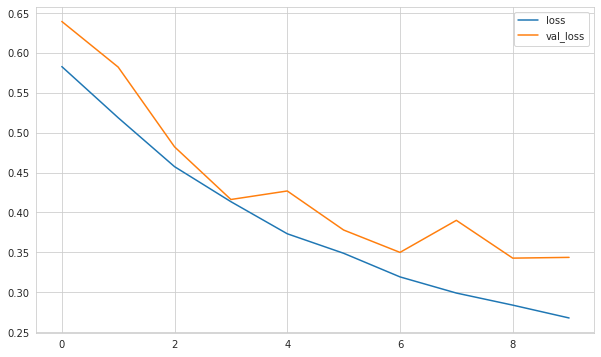

In [72]:
summary[["loss", "val_loss"]].plot();

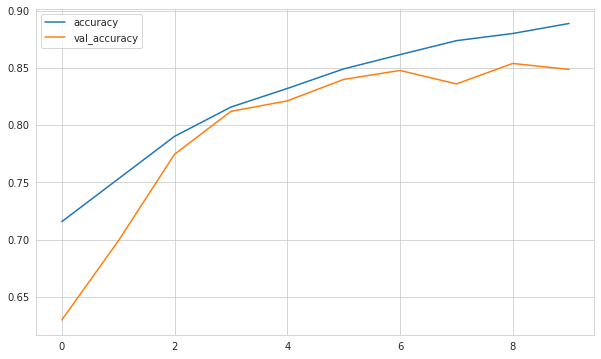

In [73]:
summary[["accuracy", "val_accuracy"]].plot();

# Modelling-2

In [74]:
model2 = Sequential()

model2.add(Conv2D(filters=16, kernel_size=(3,3),input_shape=image_shape, activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())

model2.add(Dense(128))
model2.add(Activation('relu'))

model2.add(Dense(128))
model2.add(Activation('relu'))

model2.add(Dense(1))
model2.add(Activation('sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Batch Normalization, nereye koyulduysa kendinden önceki layer'ın çıktılarını normalize eder.(Z score'a göre)
    # Bir sonraki katmana normalize ederek gönderir.
    

**Note :** Batch-Normalization (BN) is an algorithmic method which makes the training of Deep Neural Networks (DNN) faster and more stable.
It consists of normalizing activation vectors from hidden layers using the first and the second statistical moments (mean and variance) of the current batch. This normalization step is applied right before (or right after) the nonlinear function.

In [75]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 32)       128       
 hNormalization)                                                 
                                                      

In [76]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)

In [ ]:
model2.fit(train_image_gen,
          epochs=15,
          steps_per_epoch=len(train_image_gen),
          validation_data=val_image_gen,
          validation_steps=len(val_image_gen),
          callbacks=[early_stop])

Epoch 1/15
548/548 [==============================] - 104s 187ms/step - loss: 0.5375 - accuracy: 0.7446 - val_loss: 0.9851 - val_accuracy: 0.6306
Epoch 2/15
548/548 [==============================] - 104s 190ms/step - loss: 0.4477 - accuracy: 0.7940 - val_loss: 0.5964 - val_accuracy: 0.7013
Epoch 3/15
548/548 [==============================] - 103s 187ms/step - loss: 0.3869 - accuracy: 0.8285 - val_loss: 0.4133 - val_accuracy: 0.8114
Epoch 4/15
548/548 [==============================] - 104s 190ms/step - loss: 0.3400 - accuracy: 0.8550 - val_loss: 0.4733 - val_accuracy: 0.8013
Epoch 5/15
548/548 [==============================] - 102s 187ms/step - loss: 0.2981 - accuracy: 0.8724 - val_loss: 0.4394 - val_accuracy: 0.8157
Epoch 6/15
548/548 [==============================] - 103s 188ms/step - loss: 0.2697 - accuracy: 0.8844 - val_loss: 0.3241 - val_accuracy: 0.8541
Epoch 7/15
548/548 [==============================] - 103s 188ms/step - loss: 0.2477 - accuracy: 0.8938 - val_loss: 0.3002 -

In [ ]:
summary = pd.DataFrame(model2.history.history)

In [ ]:
summary[["loss", "val_loss"]].plot();

In [ ]:
summary[["accuracy", "val_accuracy"]].plot();

# Modelling-3

In [ ]:
model3 = Sequential()

model3.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', input_shape=image_shape, activation='relu'))
model3.add(BatchNormalization())
model3.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())

model3.add(Dense(128))
model3.add(Activation('relu'))

model3.add(Dense(128))
model3.add(Activation('relu'))

model3.add(Dense(1))
model3.add(Activation('sigmoid'))

model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Filtre'lerin katman sayısını artırarak daha fazla feature ve farklı feature'lar çıkarttık. Performansı böylece artırdık.
# Kernel'ların görevi zaten feature çıkartmaktı... Feature sayısı arttıkça model daha iyi öğrenir.

In [ ]:
model3.summary()

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)

In [ ]:
model3.fit(train_image_gen,
          epochs=20,
          steps_per_epoch=len(train_image_gen),
          validation_data=val_image_gen,
          validation_steps=len(val_image_gen),
          callbacks=[early_stop])

In [ ]:
# model3.save('cat_dog_detector.h5')

In [ ]:
summary = pd.DataFrame(model3.history.history)

In [ ]:
summary[["loss", "val_loss"]].plot();

In [ ]:
summary[["accuracy", "val_accuracy"]].plot();

# Evaluation on Test Data

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
score = model3.evaluate(val_image_gen)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
pred_prob = model3.predict(val_image_gen)
pred_prob

In [ ]:
y_pred = pred_prob > 0.5
y_pred

In [ ]:
y_test = val_image_gen.classes

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
model3.save('cat_dog_detector.h5')

# Prediction-1

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [ ]:
model=load_model('cat_dog_detector.h5')

In [ ]:
img_path = "/content/data/test/10005.jpg"

In [ ]:
img=image.load_img(img_path)
img

In [ ]:
img = np.array(img)
# İmage'i array'e çevirmek zorundayız.

In [ ]:
img.shape

In [ ]:
resized_img = image.smart_resize(img, (128, 128)) # img has to be numpy array 
resized_img.shape

#resized_img = img.resize((128, 128)) # img has to be image format (like jpg, png etc)
#resized_img

In [ ]:
resized_img.max()

In [ ]:
resized_img = resized_img / 255

In [ ]:
plt.imshow(resized_img)

In [ ]:
resized_img=np.expand_dims(resized_img, axis=0)
resized_img.shape
# Cnn 4 boyut istediği için 4 boyutlu hale getiriyoruz.

In [ ]:
model.predict(resized_img)

In [ ]:
val_image_gen.class_indices

# Prediction-2

In [ ]:
random_image = random.sample(os.listdir(test_path), 1)
random_image
# 2. prediction' ı random yapmak istiyoruz.

In [ ]:
image_path = test_path + random_image[0]
image_path

In [ ]:
my_image = image.load_img(image_path, target_size=image_shape)
# load image kullanırsak target_size = image_shape yapma gibi bir avantajımız var.

In [ ]:
my_image

In [ ]:
type(my_image)

In [ ]:
#my_image = np.array(my_image)
my_image = image.img_to_array(my_image)

In [ ]:
my_image.max()

In [ ]:
my_image = my_image / 255

In [ ]:
my_image.shape

In [ ]:
my_image = np.expand_dims(my_image, axis=0)
# Yine dimension' ı 1 artırdık. Çünkü CNN 4 boyutlu kabul ediyor.

In [ ]:
my_image.shape

In [ ]:
model.predict(my_image)

In [ ]:
train_image_gen.class_indices

In [ ]:
def pred_and_plot(model, img_size):
    """
    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with the predicted class as the title.
    """
    # Import the target image and preprocess it
    random_image = random.sample(os.listdir(test_path), 1)
    img_path = test_path + "/" + random_image[0]
    img = image.load_img(img_path, target_size=img_size)
    img = np.array(img)
    if img.max() > 1:
        img = img/255
  
    # Make a prediction
    pred = model.predict(np.expand_dims(img, axis=0))
    print("prediction_probability: ", pred.max())

    # Get the predicted class
    if len(pred[0]) > 1: # check for multi-class
        pred_class = class_names[pred.argmax()] # if more than one output, take the max
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

In [ ]:
pred_and_plot(model, image_shape[:2])

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="Rossum"></p>